## Loading up packages

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [3]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/ecol/'
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/ecol/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/ecol/'
gtf_name = 'Escherichia_coli_str_k_12_substr_mg1655_gca_000005845.ASM584v2.51.gtf'
mutation = 'efp'
samp_num = '1'
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [4]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [5]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [6]:
# clear up some memory by deleting original transcript list
transcripts.clear()

# Loading up the csv file.

In [7]:
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

In [8]:
elon_mutant = kat.load_elongation_rates(mutation + '_' + samp_num + '_elongation_rates', elon_path)
elon_control = kat.load_elongation_rates('control' + '_' + samp_num + '_elongation_rates', elon_path)

## Define functions

In [9]:
# Calculate the smoothed density vector pbar for xth entry with length n-9
def get_pbar_from_count(tr_m):
    M = sum(tr_m)
    p = tr_m/M
    x=0
    pbar=[]
    for px in p:
        pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
        pbar.append(pbar_x)
        x = x+1
        if x  == len(p)-9:
            break
    pbar = np.array(pbar)
    return(pbar)

## Determine KS statistic for all transcripts

In [152]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == True:
    ks_list = []
    gene_list = []
    tr_id = []
    len_list = []
    for tr_m, tr_c, transcript in zip(data_mutant, data_control, protein_coding):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.15 and sum(tr_c)/len(tr_c) > 0.15:
            position = np.array(list(range(len(tr_m))))
            smoothed_vec_m, cumul_m = kat.get_smoothed_vector(position, tr_m+0.00000000001)
            smoothed_vec_c, cumul_c = kat.get_smoothed_vector(position, tr_c+0.00000000001)
            ks = max(abs(cumul_m - cumul_c))
            ks_list.append(ks)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            len_list.append(len(tr_m))
            
    # reorganizing the lists into a dataframe. 
    df_b = pd.DataFrame(list(zip(gene_list, tr_id, ks_list, len_list)))
    df_b.columns = ["gene_ID","transcript_ID", "ks_stat", "gene_length"]
    df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)

In [153]:
df_b

,gene_ID,transcript_ID,ks_stat,gene_length
0,thrA,AAC73113,0.095609,2463
1,thrB,AAC73114,0.052162,933
2,thrC,AAC73115,0.043061,1287
3,yaaX,AAC73116,0.174143,297
4,yaaA,AAC73117,0.049708,777
...,...,...,...,...
2444,rob,AAC77349,0.090659,870
2445,creA,AAC77350,0.085364,474
2446,creB,AAC77351,0.052213,690
2447,arcA,AAC77354,0.053829,717


In [154]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df_b = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

Text(0.5, 1.0, 'KS statistic of all mouse transcripts')

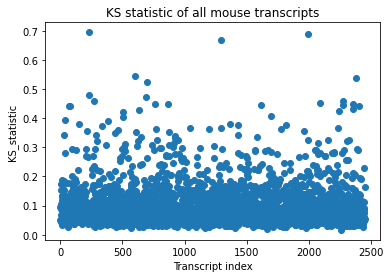

In [155]:
plt.scatter(list(range(len(df_b["ks_stat"]))), df_b["ks_stat"])
plt.ylabel("KS_statistic")
plt.xlabel("Transcript index")
plt.title("KS statistic of all mouse transcripts")

#### Alright, now how do I bin these by gene length? Quick thought, would I be able to filter out those ones I really don't like by just saying that if the maximum value is nearly equal to the sum of the entire transcript then do not count it? maybe it would not be good to cut all of that out. 

In [156]:
size_groups = []
for i in df_b["gene_length"]:
    if i < 700:
        size_groups.append(1)
    elif i >= 700 and i < 1750:
        size_groups.append(2)
    elif i >= 1750:
        size_groups.append(3)

In [157]:
df_b["size_groups"] = size_groups

In [167]:
group = df_b[(df_b['ks_stat'] > 0.40) & (df_b['size_groups'] == 2)].groupby('gene_ID')

diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [168]:
len(diff_dist)

9

In [169]:
#Add some label parameters to this and then put it in kat for gods sake. 
def big_dif(diff_dist, transcripts, data_mutant, data_control, figsize = (16,50), fontsize = 12):
    '''
    A function which creates a large graph showing the profile arrays for a list of transcripts
    
    returns a matplotlib axis object. 
    '''
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, ks, gi in zip(ax, diff_dist, diff_dist.index):
            my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts(gi, 
                                           transcripts, data_mutant, data_control)
            maxi = max([max(my_vec_mutant), max(my_vec_control)])*1.1

            axi[0].plot(my_vec_mutant)
            axi[0].text(len(my_vec_mutant)/2, maxi/1.2, "ks_stat = " + str(ks), fontsize = fontsize)
            axi[0].set_ylim([0,maxi])
            axi[0].set_ylabel("Read Counts", fontsize = fontsize)
            axi[0].set_xlabel("Codon Position", fontsize = fontsize)
            axi[0].set_title("mutant " + gi, fontsize = fontsize)
            axi[1].plot(my_vec_control)
            axi[1].set_ylim([0,maxi])
            axi[1].set_ylabel("Read Counts", fontsize = fontsize)
            axi[1].set_xlabel("Codon Position", fontsize = fontsize)
            axi[1].set_title("control " + gi, fontsize = fontsize)
    fig.tight_layout()
            
    return ax

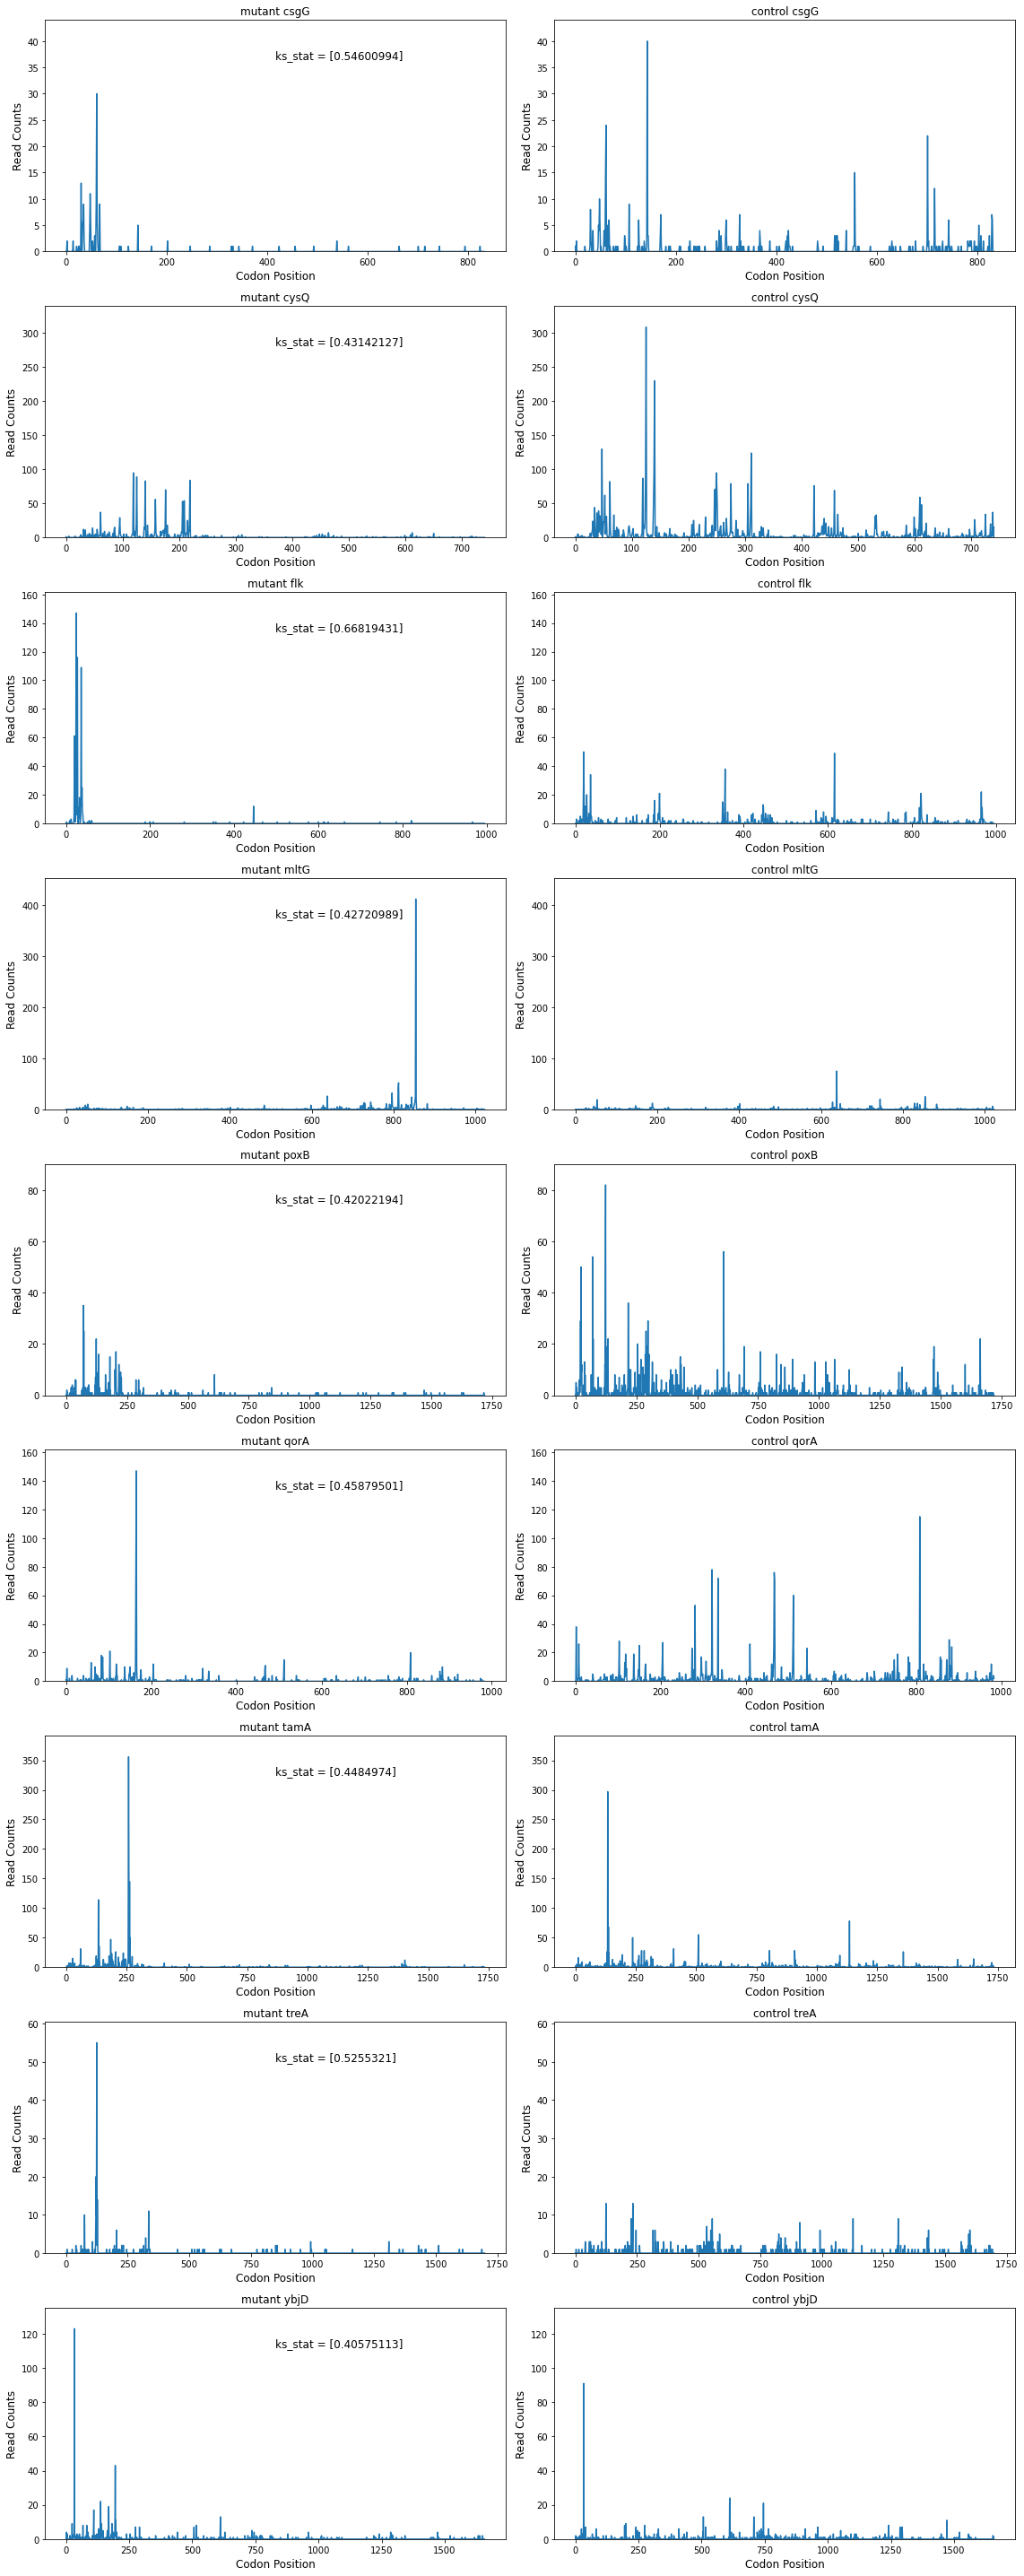

In [170]:
ax = big_dif(diff_dist, protein_coding, data_mutant, data_control, figsize = (16,40), fontsize = 12)

In [124]:
df_b[df_b["gene_ID"] == "dhaM"]

,gene_ID,transcript_ID,ks_stat,gene_length,size_groups
516,dhaM,AAC74282,0.084686,1419,2


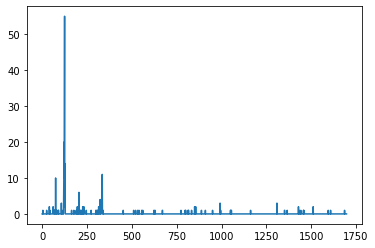

In [143]:
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts("treA", 
                                protein_coding, data_mutant, data_control)
plt.plot(my_vec_mutant)

In [144]:
sum(my_vec_mutant)/(len(my_vec_mutant))

0.17608951707891637

## Tasep-KS method

In [18]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == True:
    ks_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, el_m, el_c, transcript, i in zip(data_mutant,
                    data_control, elon_mutant, elon_control, protein_coding, list(range(len(data_mutant)))):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5 and sum(el_c) > 0 and sum(el_m) > 0:
            altered_p = kat.alter_p(el_c, el_m)
            pbar_m = get_pbar_from_count(tr_m)
            position = np.array(list(range(len(altered_p))))
            sm_m, cumul_m = kat.get_smoothed_vector(position, pbar_m+0.000001)
            sm_p, cumul_p = kat.get_smoothed_vector(position, altered_p+0.000001)
            for d, i in zip(sm_m, list(range(len(sm_m)))):
                if d < 0:
                    sm_m[i] = 0.000000000000000000001
            ks = max(abs(cumul_p - cumul_m))
            ks_list.append(ks)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            
    # reorganizing the lists into a dataframe. 
    df_t = pd.DataFrame(list(zip(gene_list, tr_id, ks_list)))
    df_t.columns = ["gene_ID","transcript_ID", "ks_stat"]

Text(0.5, 1.0, 'KS Statistic')

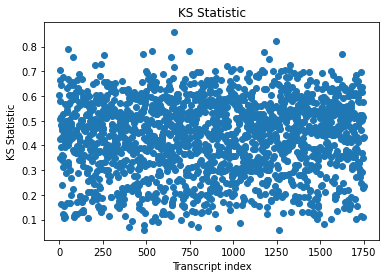

In [19]:
plt.scatter(list(range(len(df_t["ks_stat"]))), df_t["ks_stat"])
plt.ylabel("KS Statistic")
plt.xlabel("Transcript index")
plt.title("KS Statistic")

In [48]:
group = df_t[(df_t['ks_stat'] > 0.2) & (df_t['ks_stat'] < 0.205)].groupby('gene_ID')

diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [49]:
len(diff_dist)

11

In [50]:
def big_dif(diff_dist, transcripts, data_mutant, data_control, figsize = (16,50), fontsize = 12):
    '''
    A function which creates a large graph showing the profile arrays for a list of transcripts
    
    returns a matplotlib axis object. 
    '''
    fig,ax = plt.subplots(len(diff_dist), 2, figsize = figsize)
    for axi, ks, gi in zip(ax, diff_dist, diff_dist.index):
            my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts(gi, 
                                           transcripts, data_mutant, data_control)
            maxi = max([max(my_vec_mutant), max(my_vec_control)])*1.1

            axi[0].plot(my_vec_mutant)
            axi[0].text(len(my_vec_mutant)/2, maxi/1.2, "ks_stat = " + str(ks), fontsize = fontsize)
            axi[0].set_ylim([0,maxi])
            axi[0].set_ylabel("Read Counts", fontsize = fontsize)
            axi[0].set_xlabel("Codon Position", fontsize = fontsize)
            axi[0].set_title("mutant " + gi, fontsize = fontsize)
            axi[1].plot(my_vec_control)
            axi[1].set_ylim([0,maxi])
            axi[1].set_ylabel("Read Counts", fontsize = fontsize)
            axi[1].set_xlabel("Codon Position", fontsize = fontsize)
            axi[1].set_title("control " + gi, fontsize = fontsize)
    fig.tight_layout()
            
    return ax

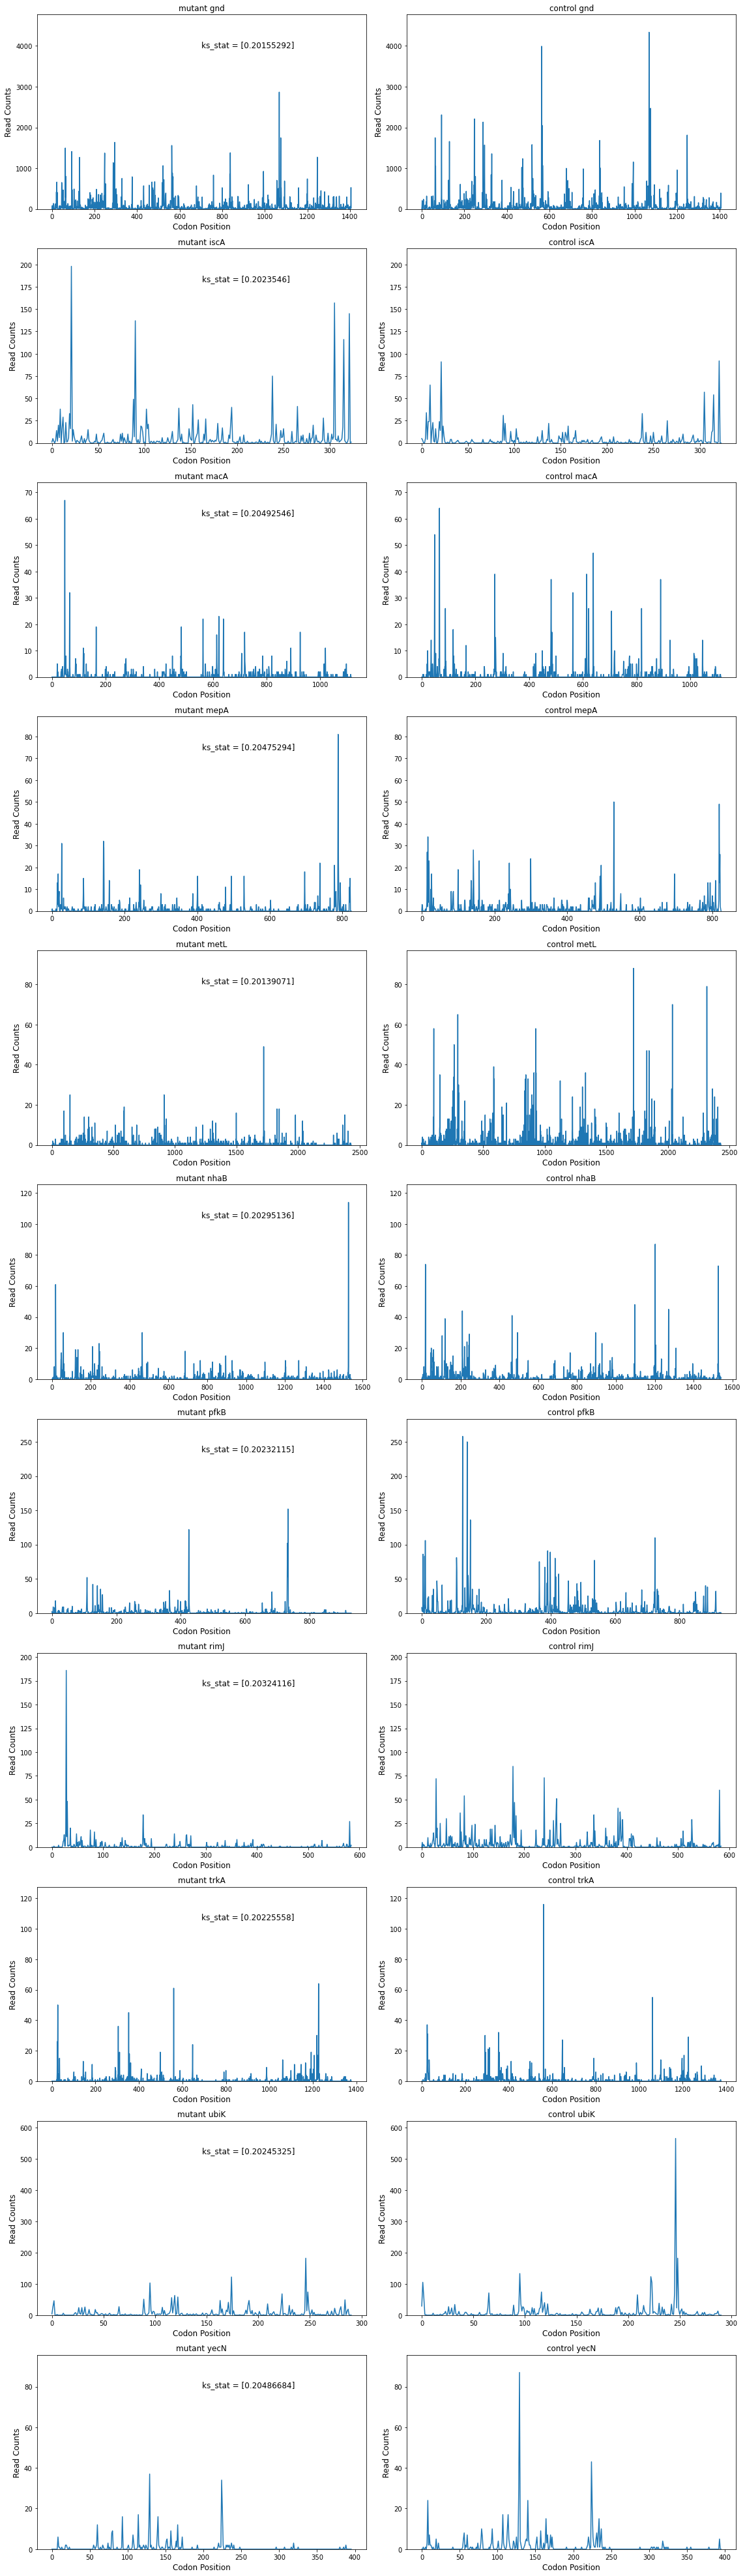

In [51]:
ax = big_dif(diff_dist, protein_coding, data_mutant, data_control, figsize = (16,55), fontsize = 12)

## Choose a gene of interest and observe the smooth and unsmooth array.

In [87]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts('malZ', 
                                           protein_coding, data_mutant, data_control)

In [88]:
index

385

In [47]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

In [48]:
sum(my_vec_control)

596

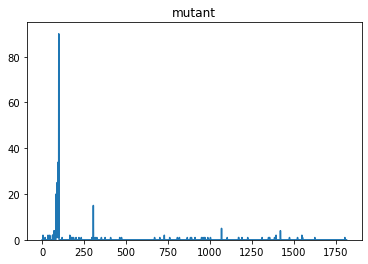

Text(0.5, 1.0, 'control')

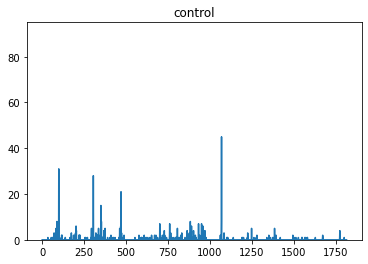

In [49]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])

plt.plot(my_vec_mutant)
plt.ylim([0,maxi+5])
plt.title("mutant")
plt.show()
plt.plot(my_vec_control)
plt.ylim([0,maxi+5])
plt.title("control")

When looking at the absolute largest values of P, we find this shape where the reads completely smooth out over time very consistently. 

In [56]:
sum(my_vec_control)

596

In [51]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_position, my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_position, my_vec_control+0.00000000001)

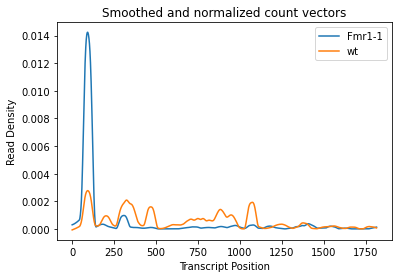

In [52]:
plt.plot(smoothed_vec_m, label = "Fmr1-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and normalized count vectors")
plt.legend()

## Plot and calculate the correlation of the cumulative sum * The transcript position

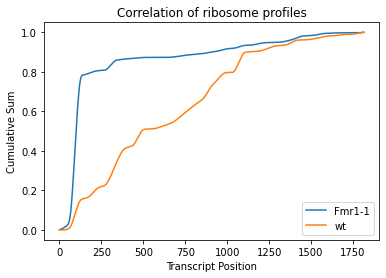

In [53]:
plt.plot(my_position, cumul_m, label = "Fmr1-1")
plt.plot(my_position, cumul_c, label = "wt")
plt.ylabel("Cumulative Sum")
plt.xlabel("Transcript Position")
plt.title("Correlation of ribosome profiles")
plt.legend()

In [54]:
ks = max(abs(cumul_m - cumul_c))
n = len(my_vec_mutant)
m = len(my_vec_control)
en = (n*m)/(n+m)
p = kstwo.sf(ks,np.round(en))

In [55]:
p

0.0

Wait a second, if I am using the cumulative sum for these KS-tests than wouldn't the P-values scale up with the length of the transcript since the function is going to take the number of inputs as the number of independent samples? like, if it sees a bunch of zeroes it is going to think that we actually ran a test and got a bunch of zeroes wont it? and this would apply to the normal data too. 

Play around with just the Fmr1 targets until we are seeing that at least half of them are not being filtered out by our read density thingy. 